# Results CIFAR-10 Visualizations for XMI (clean cold start)
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/xmi_cifar10_1_clean")

In [ ]:
get_any(results).config

_config(seed=6667, id_dataset_name='CIFAR-10', initial_training_set_size=1000, validation_set_size=5000, evaluation_set_size=0, id_repetitions=1, add_dataset_noise=False, validation_split_random_state=0, acquisition_size=5, max_training_set=20000, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, max_training_epochs=60, training_batch_size=128, device='cuda', min_samples_per_epoch=5056, patience_schedule=[3, 3, 3], factor_schedule=[0.1], acquisition_function='batchbald_redux.acquisition_functions.BatchCoreSetBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.resnet_models.Cifar10BayesianResnetFactory', acquisition_function_args=None, temperature=0.0)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,1,1622062468
1,2,1622062449
2,3,1622062451
3,6,1622148903
4,9,1622148883
5,13,1622217357
6,12,1622217359
7,5,1622062447
8,10,1622148910
9,8,1622148898


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

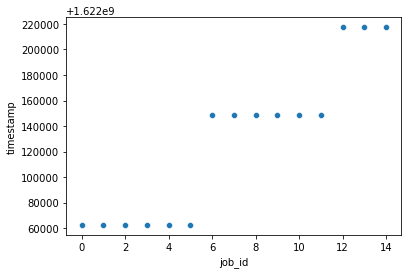

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(15, 15)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

       
    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    num_pool_samples = result.config.num_pool_samples
    
    seed = result.config.seed

    if acquisition_function == "Random":
        acquisition_sizes = [5]
    else:
        acquisition_sizes = [acquisition_size]
        
    if acquisition_function == "Random":
        num_pool_samples = [100]
    else:
        num_pool_samples = [num_pool_samples]
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * result.config.acquisition_size
                < 100
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * result.config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        seed=seed,
                    )
                )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed
0,BatchCoreSetBALD,5,100,1000,0.5598,6667
1,BatchCoreSetBALD,5,100,1005,0.5714,6667
2,BatchCoreSetBALD,5,100,1010,0.5593,6667
3,BatchCoreSetBALD,5,100,1015,0.5796,6667
4,BatchCoreSetBALD,5,100,1020,0.6034,6667
...,...,...,...,...,...,...
5774,BatchBALD,5,100,2765,0.6470,6666
5775,BatchBALD,5,100,2770,0.6882,6666
5776,BatchBALD,5,100,2775,0.7269,6666
5777,BatchBALD,5,100,2780,0.7166,6666


In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.groupby(["acquisition_size", "acquisition_function"])["seed"].nunique()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 BatchBALD               5
                  BatchCoreSetBALD        5
                  Random                  5
Name: num_trials, dtype: int64


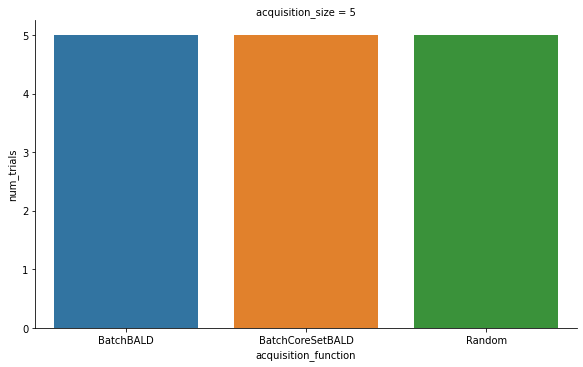

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

In [ ]:
dff = df.groupby(["acquisition_function", "seed"]).rolling(window=10, on="training_set_size")["accuracy"].mean()
dff = dff.reset_index()
dff

,acquisition_function,seed,training_set_size,accuracy
0,BatchBALD,6666,1000,NaN
1,BatchBALD,6666,1005,NaN
2,BatchBALD,6666,1010,NaN
3,BatchBALD,6666,1015,NaN
4,BatchBALD,6666,1020,NaN
...,...,...,...,...
5774,Random,6684,3100,0.69656
5775,Random,6684,3105,0.69780
5776,Random,6684,3110,0.69716
5777,Random,6684,3115,0.69518


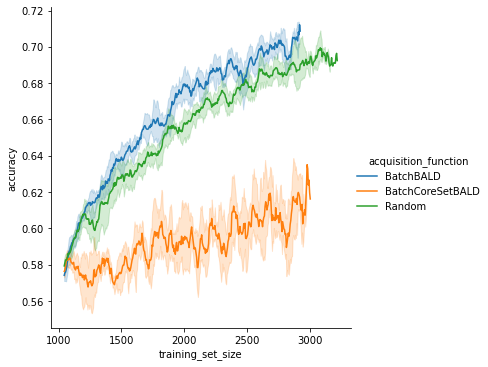

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    #col="acquisition_size",
    #col="xmi_type",
    hue="acquisition_function",
    data=dff,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
import qgrid

df["max_accuracy"] = df.groupby(["seed", "acquisition_size", "acquisition_function"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,max_accuracy
0,BALD,1,100,0,0.1178,6,0.1178
2,BALD,1,100,2,0.2075,6,0.2075
3,BALD,1,100,3,0.2537,6,0.2537
4,BALD,1,100,4,0.3290,6,0.3290
5,BALD,1,100,5,0.3791,6,0.3791
...,...,...,...,...,...,...,...
2958,Random,1,100,110,0.8742,22,0.8742
2959,Random,1,100,115,0.8805,22,0.8805
2960,Random,1,100,120,0.8812,22,0.8812
2962,Random,1,100,130,0.8977,22,0.8977


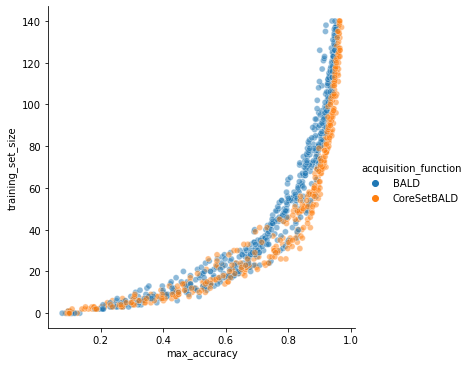

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    #col="xmi_type",
    hue="acquisition_function",
    data=df_max_accuracy[df_max_accuracy.acquisition_function != "Random"],
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "Random")].groupby(["seed", "acquisition_size", "acquisition_function"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                        0.25  0.50  0.75
acquisition_size acquisition_function                   
1                BALD                  83.75  88.0  94.0
                 CoreSetBALD           67.50  69.5  77.0


In [ ]:
df2 = df[(df.accuracy >= 0.95) & (df.acquisition_function != "Random")].groupby(["seed", "acquisition_size", "acquisition_function",]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function",]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                         0.25   0.50   0.75
acquisition_size acquisition_function                      
1                BALD                  135.00  135.5  136.0
                 CoreSetBALD           114.25  116.5  120.0
